In [1]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import requests
import json
import ast
import yaml
import urllib
import yfinance
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
#from google.colab import drive

In [3]:
df_tweets = pd.read_csv('https://raw.githubusercontent.com/ml-group8/assignment/main/df_tweets_sentiment_3_analyzers.csv')
df_tweets

,Unnamed: 0,created_at,tweet,flare_sentiment,flare_confidence,txtblob_sentiment,txtblob_subjectivity,vader_sentiment,vader_compound_score
0,0,2021-03-20T15:59:46.000Z,I agree. I was looking to buy an electric car...,NEGATIVE,0.999987,NEGATIVE,0.495000,NEGATIVE,-0.6478
1,1,2021-03-20T15:59:30.000Z,"RT : this line read is so funny!??!?! ""WHERESM...",NEGATIVE,0.999818,POSITIVE,1.000000,POSITIVE,0.7826
2,2,2021-03-20T15:59:09.000Z,"RT : this line read is so funny!??!?! ""WHERESM...",NEGATIVE,0.999840,POSITIVE,1.000000,POSITIVE,0.7826
3,3,2021-03-20T15:59:03.000Z,Germany electric car and 60% US states margin...,NEGATIVE,0.975843,POSITIVE,0.200000,POSITIVE,0.4576
4,4,2021-03-20T15:58:49.000Z,Germany electric car and 60% US states margin...,NEGATIVE,0.975843,POSITIVE,0.200000,POSITIVE,0.4576
...,...,...,...,...,...,...,...,...,...
15143,15143,2021-03-13T17:01:27.000Z,"#Goodyearsbar #Timbo, Our #ClubCar limited sli...",POSITIVE,0.999870,NEGATIVE,0.142857,POSITIVE,0.0516
15144,15144,2021-03-13T17:01:15.000Z,Toyota X-Prologue Electric Car Teased Ahead of...,POSITIVE,0.970047,POSITIVE,0.166667,NEGATIVE,-0.2960
15145,15145,2021-03-13T17:00:56.000Z,I’m driving fossil fuel out of my economy. I...,NEGATIVE,0.834038,NEGATIVE,0.000000,NEGATIVE,0.0000
15146,15146,2021-03-13T17:00:37.000Z,Imagine buying an electric car to charge it at...,NEGATIVE,0.997597,NEGATIVE,0.000000,NEGATIVE,0.0000


In [4]:
# Keep only required columns
df_tweets = df_tweets[['created_at', 'tweet', 'flare_sentiment', 'txtblob_sentiment','vader_sentiment']]

# Convert created_at column from string to datetime
def string_to_datetime(str_date):
  str_date = str_date[:19]
  return datetime.strptime(str_date, "%Y-%m-%dT%H:%M:%S")

df_tweets['created_at'] = df_tweets['created_at'].map(lambda strDateTime: string_to_datetime(strDateTime))
max_date_tweets = df_tweets['created_at'].max().replace(minute=0, second=0, microsecond=0)
min_date_tweets = df_tweets['created_at'].min().replace(minute=0, second=0, microsecond=0)

df_tweets
#print(min_date_tweets)
#print(max_date_tweets)

C:\Users\Vida\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,created_at,tweet,flare_sentiment,txtblob_sentiment,vader_sentiment
0,2021-03-20 15:59:46,I agree. I was looking to buy an electric car...,NEGATIVE,NEGATIVE,NEGATIVE
1,2021-03-20 15:59:30,"RT : this line read is so funny!??!?! ""WHERESM...",NEGATIVE,POSITIVE,POSITIVE
2,2021-03-20 15:59:09,"RT : this line read is so funny!??!?! ""WHERESM...",NEGATIVE,POSITIVE,POSITIVE
3,2021-03-20 15:59:03,Germany electric car and 60% US states margin...,NEGATIVE,POSITIVE,POSITIVE
4,2021-03-20 15:58:49,Germany electric car and 60% US states margin...,NEGATIVE,POSITIVE,POSITIVE
...,...,...,...,...,...
15143,2021-03-13 17:01:27,"#Goodyearsbar #Timbo, Our #ClubCar limited sli...",POSITIVE,NEGATIVE,POSITIVE
15144,2021-03-13 17:01:15,Toyota X-Prologue Electric Car Teased Ahead of...,POSITIVE,POSITIVE,NEGATIVE
15145,2021-03-13 17:00:56,I’m driving fossil fuel out of my economy. I...,NEGATIVE,NEGATIVE,NEGATIVE
15146,2021-03-13 17:00:37,Imagine buying an electric car to charge it at...,NEGATIVE,NEGATIVE,NEGATIVE


In [5]:
from datetime import datetime, timedelta, timezone

#A/p the yfinance docs, Note: yahoo finance datetimes are received as UTC.
#however when visualizing the df the Datetime field is UTC-4 ???
drive_etf_ticker = yfinance.Ticker("DRIV")
drive_etf = drive_etf_ticker.history(
    start=min_date_tweets.strftime('%Y-%m-%d'),
    end=max_date_tweets.strftime('%Y-%m-%d'),
    interval='60m'
).reset_index()

# The Yahoo finance are in EST so convert them to UTC to match the tweets' timezone
drive_etf['DatetimeUTC'] = drive_etf['Datetime'].dt.tz_convert('UTC')
# Remove the timezone since we know it is at UTC and the tweets dataframe index is not tz aware
drive_etf['DatetimeUTC'] = drive_etf['Datetime'].dt.tz_convert(tz=None)

#set new UTC datetime as the index, we can visually compare to the original column to see the timezone correction
drive_etf.index = drive_etf['DatetimeUTC']
del drive_etf['DatetimeUTC']

drive_etf['pct_change'] = drive_etf['Close'].pct_change().fillna(0)
drive_etf = drive_etf[['pct_change', 'Close']]
#Let's only keep pct_change as our key dependent var and Close simply for debugging

drive_etf.head()

,pct_change,Close
DatetimeUTC,,
2021-03-15 13:30:00,0.000000,27.389999
2021-03-15 14:30:00,-0.004381,27.270000
2021-03-15 15:30:00,0.001100,27.299999
2021-03-15 16:30:00,0.001062,27.329000
2021-03-15 17:30:00,0.003326,27.419901


In [6]:
# ETF 
# min: 2021-03-15 13:30
# max: 2021-03-19 19:30

# Tweets
# Min: 2021-03-13 17:00:02
# Max: 2021-03-20 15:59:46

## Resampling #####3

# Convert sentiment to numeric (Positive=1, negative=0)
df_tweets['flare_numeric_sentiment'] = np.where(df_tweets['flare_sentiment'] == 'POSITIVE', 1, 0)
df_tweets['vader_numeric_sentiment'] = np.where(df_tweets['vader_sentiment'] == 'POSITIVE', 1, 0)
df_tweets['txtblob_numeric_sentiment'] = np.where(df_tweets['txtblob_sentiment'] == 'POSITIVE', 1, 0)

# The ETF dataframe times are hourly but starting at 30min. We wil ladjust the tweets to match so we can join later
# It should still represent the general feeling at the hour+30min
df_tweets['created_at'] = df_tweets['created_at'].map(lambda created_at: created_at.round('H').replace(minute=30))
df_tweets


C:\Users\Vida\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\Vida\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\Vida\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

,created_at,tweet,flare_sentiment,txtblob_sentiment,vader_sentiment,flare_numeric_sentiment,vader_numeric_sentiment,txtblob_numeric_sentiment
0,2021-03-20 16:30:00,I agree. I was looking to buy an electric car...,NEGATIVE,NEGATIVE,NEGATIVE,0,0,0
1,2021-03-20 16:30:00,"RT : this line read is so funny!??!?! ""WHERESM...",NEGATIVE,POSITIVE,POSITIVE,0,1,1
2,2021-03-20 16:30:00,"RT : this line read is so funny!??!?! ""WHERESM...",NEGATIVE,POSITIVE,POSITIVE,0,1,1
3,2021-03-20 16:30:00,Germany electric car and 60% US states margin...,NEGATIVE,POSITIVE,POSITIVE,0,1,1
4,2021-03-20 16:30:00,Germany electric car and 60% US states margin...,NEGATIVE,POSITIVE,POSITIVE,0,1,1
...,...,...,...,...,...,...,...,...
15143,2021-03-13 17:30:00,"#Goodyearsbar #Timbo, Our #ClubCar limited sli...",POSITIVE,NEGATIVE,POSITIVE,1,1,0
15144,2021-03-13 17:30:00,Toyota X-Prologue Electric Car Teased Ahead of...,POSITIVE,POSITIVE,NEGATIVE,1,0,1
15145,2021-03-13 17:30:00,I’m driving fossil fuel out of my economy. I...,NEGATIVE,NEGATIVE,NEGATIVE,0,0,0
15146,2021-03-13 17:30:00,Imagine buying an electric car to charge it at...,NEGATIVE,NEGATIVE,NEGATIVE,0,0,0


In [7]:
# count positive and negative tweets and convert them into a ratio of positive tweets to total tweets
df_tweet_sentiment_by_hr = df_tweets.assign(
 nb_flare_positive = np.where(df_tweets['flare_numeric_sentiment']==1,1,0),
 nb_flare_negative = np.where(df_tweets['flare_numeric_sentiment']==0,1,0),
 nb_vader_positive = np.where(df_tweets['vader_numeric_sentiment']==1,1,0),
 nb_vader_negative = np.where(df_tweets['vader_numeric_sentiment']==0,1,0),
 nb_txtblob_positive = np.where(df_tweets['txtblob_numeric_sentiment']==1,1,0),
 nb_txtblob_negative = np.where(df_tweets['txtblob_numeric_sentiment']==0,1,0) 
  ).groupby('created_at').agg({'nb_flare_positive':sum, 'nb_flare_negative':sum,'nb_vader_positive':sum, 'nb_vader_negative':sum,'nb_txtblob_positive':sum, 'nb_txtblob_negative':sum})

df_tweet_sentiment_by_hr['flare_positive_ratio'] = df_tweet_sentiment_by_hr['nb_flare_positive']/(df_tweet_sentiment_by_hr['nb_flare_positive'] + df_tweet_sentiment_by_hr['nb_flare_negative'])
df_tweet_sentiment_by_hr['vader_positive_ratio'] = df_tweet_sentiment_by_hr['nb_vader_positive']/(df_tweet_sentiment_by_hr['nb_vader_positive'] + df_tweet_sentiment_by_hr['nb_vader_negative'])
df_tweet_sentiment_by_hr['txtblob_positive_ratio'] = df_tweet_sentiment_by_hr['nb_txtblob_positive']/(df_tweet_sentiment_by_hr['nb_txtblob_positive'] + df_tweet_sentiment_by_hr['nb_txtblob_negative'])

df_tweet_sentiment_by_hr.head()
#2021-03-15 13:30:00+00:00


#TODO: Maybe remove re=tweets (RT : prefix ???)
# TODO: Plug holes with after-hours info ???

,nb_flare_positive,nb_flare_negative,nb_vader_positive,nb_vader_negative,nb_txtblob_positive,nb_txtblob_negative,flare_positive_ratio,vader_positive_ratio,txtblob_positive_ratio
created_at,,,,,,,,,
2021-03-13 17:30:00,25,8,19,14,17,16,0.757576,0.575758,0.515152
2021-03-13 18:30:00,53,32,31,54,42,43,0.623529,0.364706,0.494118
2021-03-13 19:30:00,27,25,23,29,26,26,0.519231,0.442308,0.500000
2021-03-13 20:30:00,104,26,87,43,99,31,0.800000,0.669231,0.761538
2021-03-13 21:30:00,87,27,77,37,84,30,0.763158,0.675439,0.736842


In [8]:
def plot_sentiment_and_stock_price(prices, sentiment_positive_ratio):
  plt.rcParams['figure.figsize']=(8,2) # set the figure size
  plt.rcParams.update({'font.size': 12})
  fig, ax1 = plt.subplots()
  ax2 = ax1.twinx()  # set up the 2nd axis
  ax1.plot(prices, color='black', linewidth=2.5, label='Stock price') 
  ax1.set_xlabel('Datetime', fontweight='bold')
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
  ax1.set_ylabel('DRIV stock price', fontweight='bold')
  ax2.plot(sentiment_positive_ratio, color='red', linestyle='dashed', label='Sentiment positive ratio')
  ax2.set_ylabel('Sentiment positive ratio', fontweight='bold')
  fig.legend(loc='upper center', ncol=2)

C:\Users\Vida\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


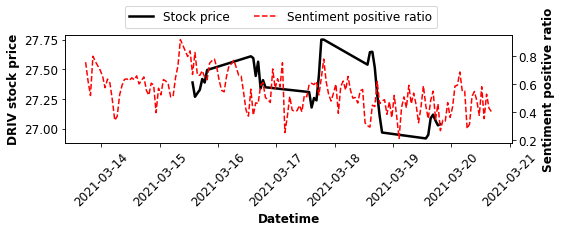

In [9]:
# Smooth the curve
df_tweet_sentiment_by_hr['flare_positive_ratio_mov_avg'] = df_tweet_sentiment_by_hr['flare_positive_ratio'].rolling(24).sum()

plot_sentiment_and_stock_price(drive_etf['Close'], df_tweet_sentiment_by_hr['flare_positive_ratio'])

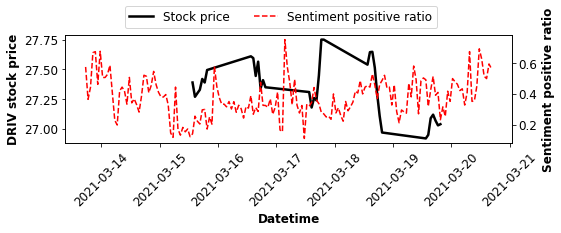

In [10]:
# Vader

plot_sentiment_and_stock_price(drive_etf['Close'], df_tweet_sentiment_by_hr['vader_positive_ratio'])

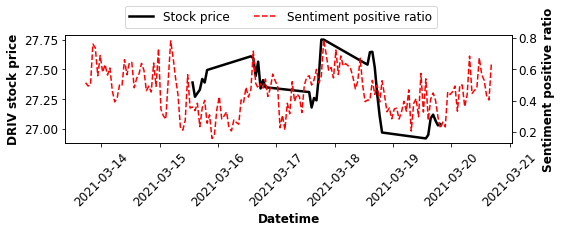

In [11]:
# Text Blob

plot_sentiment_and_stock_price(drive_etf['Close'], df_tweet_sentiment_by_hr['txtblob_positive_ratio'])

In [12]:
# Merge the tweets and stocks

# No need to strip out non-matching days as join is left join by default
df_merged = drive_etf.join(df_tweet_sentiment_by_hr)

#Keep only columns we need for the analysis
df_merged = df_merged[['Close', 'flare_positive_ratio','vader_positive_ratio','txtblob_positive_ratio']]
df_merged.head()

,Close,flare_positive_ratio,vader_positive_ratio,txtblob_positive_ratio
DatetimeUTC,,,,
2021-03-15 13:30:00,27.389999,0.670000,0.140000,0.360000
2021-03-15 14:30:00,27.270000,0.826531,0.255102,0.336735
2021-03-15 15:30:00,27.299999,0.666667,0.222222,0.383838
2021-03-15 16:30:00,27.329000,0.663265,0.204082,0.234694
2021-03-15 17:30:00,27.419901,0.696296,0.296296,0.355556


In [13]:
# Feature engineer the previous hour's closing price

df = df_merged.copy()
prev_hour_close_price = df.shift(periods=1).fillna(method='backfill')[['Close']]
prev_hour_close_price = prev_hour_close_price.rename(columns={"Close": "PrevClose"})
prev_hour_close_price

df2 = df.join(prev_hour_close_price)

In [14]:
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
import numpy as np


def run_random_forest(X, y):
    # to make this notebook's output stable across runs
    np.random.seed(123)

    X_train, X_test, y_train, y_test = train_test_split(X, y)

    np.random.seed(123)
    model_rf = RandomForestRegressor(n_estimators=500, oob_score=True)
    model_rf.fit(X_train, y_train) 
    pred_train_rf= model_rf.predict(X_train)

    print('Training r-squared score : ' + str(r2_score(y_train, pred_train_rf)))

    pred_test_rf = model_rf.predict(X_test)
    print('Testing r-squared score : ' + str(r2_score(y_test, pred_test_rf)))
    df_actual = pd.DataFrame(y_test)
    df_pred = pd.DataFrame(pred_test_rf, index=df_actual.index)
    df_actual_pred = pd.concat([df_actual, df_pred], axis=1)
    return df_actual_pred

y = df['Close']

print('\nRandom Forest with Flare sentiment\n')
X = df2.copy()[['flare_positive_ratio', 'PrevClose']]
pred_X1 = run_random_forest(X, y)

print('\nRandom Forest with Vader sentiment\n')
X = df2.copy()[['vader_positive_ratio', 'PrevClose']]
pred_X2 = run_random_forest(X, y)

print('\nRandom Forest with TextBlob sentiment\n')
X = df2.copy()[['txtblob_positive_ratio', 'PrevClose']]
pred_X3 = run_random_forest(X, y)

print('\nRandom Forest with all sentiments\n')
X = df2.copy()[['txtblob_positive_ratio', 'vader_positive_ratio', 'flare_positive_ratio', 'PrevClose']]
pred_X4 = run_random_forest(X, y)


Random Forest with Flare sentiment

Training r-squared score : 0.9352343315236256
Testing r-squared score : 0.610144481625054

Random Forest with Vader sentiment

Training r-squared score : 0.9491031567134328
Testing r-squared score : 0.6496209555359236

Random Forest with TextBlob sentiment

Training r-squared score : 0.9577227064641741
Testing r-squared score : 0.7271068279264735

Random Forest with all sentiments

Training r-squared score : 0.9424047188840486
Testing r-squared score : 0.7707965410703868


In [15]:
series_df1 = pred_X1.rename(columns={0: "flair"})
series_df2 = pred_X2.rename(columns={0: "vader"})
series_df3 = pred_X3.rename(columns={0: "textblob"})
series_df4 = pred_X4.rename(columns={0: "all"})
series_df = pd.concat([series_df1, series_df2['vader'], series_df3['textblob'], series_df4['all']], axis=1)
series_df

,Close,flair,vader,textblob,all
DatetimeUTC,,,,,
2021-03-15 19:30:00,27.495001,27.299865,27.378141,27.319899,27.353542
2021-03-19 15:30:00,27.090000,26.965930,27.005012,27.041555,27.053344
2021-03-15 18:30:00,27.389999,27.539372,27.469668,27.489470,27.456371
2021-03-16 18:30:00,27.410000,27.278661,27.335756,27.299793,27.334565
2021-03-18 16:30:00,27.514999,27.589215,27.593910,27.565769,27.565211
2021-03-16 14:30:00,27.594999,27.580957,27.646573,27.677747,27.651895
2021-03-19 14:30:00,26.950001,26.977031,27.072428,27.029895,27.082035
2021-03-16 17:30:00,27.340300,27.517802,27.591131,27.486490,27.487470
2021-03-16 19:30:00,27.350000,27.394952,27.349698,27.379478,27.393486


In [16]:
def plot_actual_vs_predicted(actual_prices, predicted_prices, color, title):
    plt.rcParams['figure.figsize']=(4,4) # set the figure size
    plt.rcParams.update({'font.size': 12})
    plt.plot(actual_prices, predicted_prices, linestyle='none', marker='o', color=color)
    plt.xlabel('Actual Price', fontweight='bold')
    plt.ylabel('Predicted Price', fontweight='bold')
    plt.title(title, fontweight='bold')
    #Plotting the identity line:
    x_min = actual_prices.min()
    x_max = actual_prices.max()
    y_min = predicted_prices.min()
    y_max = predicted_prices.max()
    x_lim = [x_min,x_max]
    y_lim = [y_min,y_max]
    if y_max > x_max:
        if y_min > x_min:
            plt.plot(x_lim, y_lim, linewidth=2, linestyle='dashed', color='dimgrey')
        else:
            plt.plot(y_lim, y_lim, linewidth=2, linestyle='dashed', color='dimgrey')
    else:
        if y_min > x_min:
            plt.plot(x_lim, x_lim, linewidth=2, linestyle='dashed', color='dimgrey')
        else:
            plt.plot(y_lim, x_lim, linewidth=2, linestyle='dashed', color='dimgrey')

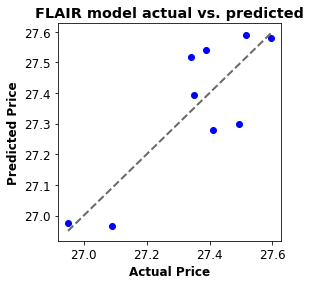

In [17]:
plot_actual_vs_predicted(series_df['Close'], series_df['flair'], color='blue', title='FLAIR model actual vs. predicted')

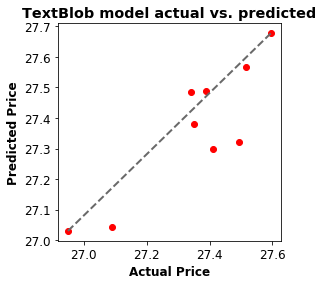

In [18]:
plot_actual_vs_predicted(series_df['Close'], series_df['textblob'], color='red', title='TextBlob model actual vs. predicted')

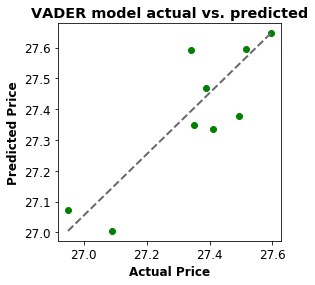

In [19]:
plot_actual_vs_predicted(series_df['Close'], series_df['vader'], color='green', title='VADER model actual vs. predicted')

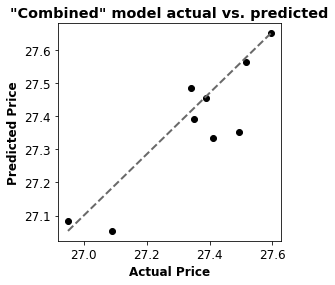

In [20]:
plot_actual_vs_predicted(series_df['Close'], series_df['all'], color='black', title='"Combined" model actual vs. predicted')